<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Определение тональности комментариев</h1>

Нужно обучить модель классифицировать комментарии на позитивные и негативные. Целевая метрика - f1. Нужно получить значение на тестовой выборке не ниже 0.75. 

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Введение</h1>

В работе опирался на [Ваш первый BERT: иллюстрированное руководство](https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb), [Smart batchin tutorial](https://colab.research.google.com/drive/1Er23iD96x_SzmRG8md1kVggbmz0su_Q5#scrollTo=Sa7tgw2-Pttq), [Lena VoitaNLP course]( https://lena-voita.github.io/nlp_course/text_classification.html), [kaggle mini course Natural Language Processing](https://www.kaggle.com/learn/natural-language-processing), [Подходы лемматизации с примерами на Python](https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/)

Попробовал spaCy и BERT (и DistilBERT) от transformers, и можно было ещё попробовать реализации word2vec от spaCy и разные языковые модели. Возможно, можно было как-то улучшить показатели комбинациями vectorizer-pca-gradient boosting. Не стал включать в тетрадку, т.к. предварительные результаты были хуже логистической регрессии, тюнинг бустинга на таком наборе данных очень затратен по времени, а логистическая регрессия вполне справилась с задачей.

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">1. Загрузка данных, общая информация</h1>

In [1]:
#!conda install -c conda-forge spacy
#!python -m spacy download en_core_web_sm
#!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import re #регулярные выражения для очистки текста
import random
import torch #для тензоров BERT
import csv #для записи эмбеддингов

from tqdm import notebook #для отслеживания прогресса
from datetime import datetime #для оценки времени лемматизации

#BERT от transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer

#spaCy
import spacy
from spacy.pipeline import TextCategorizer
from spacy.util import minibatch

#natural language toolkit
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#векторизация, метрики, пайплайн, подготовка данных, модели от sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from catboost import CatBoostClassifier

In [3]:
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')

In [4]:
#функция для вывода отчёта о прогнозе модели
def print_report(true, predicted):
    
    report = classification_report(true, predicted)
    roc_auc = roc_auc_score(true, predicted)

    cm = confusion_matrix(true, predicted)
    cm_df = pd.DataFrame(data=cm, index=['Actual NO', 'Actual YES'], columns = ['Predicted NO', 'Predicted YES'])
    display(cm_df)
    print(f'{"report":-^60}\n\n', report)
    print( 'ROC_AUC:', round(roc_auc,2) )

In [5]:
#функция для удаления из текста никнеймов и проч.
def text_cleaner(raw):
    return " ".join(re.sub(r'[^a-zA-Z\']', ' ', raw).split())

In [6]:
#функция возвращает кортеж с тегом «part-of-speech»
#взята с https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [7]:
#функция для лемматизации на базе nltk
def ntlk_text_lemmatizer(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = ''
    for w in nltk.word_tokenize(row):
        lemmatized_row += lemmatizer.lemmatize(w, get_wordnet_pos(w)) + ' '
        
    return lemmatized_row

In [8]:
#функция для лемматизации на базе spacy
def spacy_text_lemmatizer(raw):
    doc = nlp(raw)
    return " ".join([token.lemma_ for token in doc])

In [9]:
#функция для кросс-валидации с векторизацией
def cross_val_func(model, vectorizer, features, target):
    pipe = \
    Pipeline(steps = [('vectorizer', vectorizer),
                      ('model', model)])
    cv_score = cross_val_score(pipe, features, target, cv=5, scoring='f1')
    print('Cross-validation results, f1', cv_score)
    print('Cross-validation mean score, f1', cv_score.mean())

In [10]:
link='datasets/ML/'
df = pd.read_csv(link + 'toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [12]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [13]:
df.duplicated().sum()

0

Данные - объёмный (почти 160 тыс. объектов) датасет с сильно разбалансированными классами. Без дублей и пропусков. Требуется очистка текста от спецсимволов и проч.

In [14]:
df['text'] = df['text'].astype('U')

In [15]:
df['text'] = df['text'].apply(text_cleaner)

//ремарка:

Уже после обучения BERT и spaCy на полном датасете я выяснил, что часть (1243) комментариев содержала только цифры; вероятно, цифры не стоило очищать. Однако для BERT датасет (полный, а не тот, который я привёл в тетрадке) был получен уже без цифр, поэтому не стал переделывать это, чтобы можно было сравнить результаты. В принципе, можно было поработать с текстом, проверить на пустые комментарии, комментарии только с цифрами и т.д. Возможно, стоило оставлять скобки и двоеточия и выделить эмодзи. Варианты для предобработки есть. Если развивать проект, можно экспериментировать.

In [16]:
df.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D'aww He matches this background colour I'm se...,0
2,Hey man I'm really not trying to edit war It's...,0
3,More I can't make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0


<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">2. Классический подход: Naive Bayes Classifier, Logistic Regression</h1>

<h2 style="color:DodgerBlue">2.1 Лемматизация</h2>

Сравню два варианта лемматизации: на базе Natural Language Toolkit и на базе spaCy. Для spaCy возьму самую лёгкую модель [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) (English multi-task CNN trained on OntoNotes. Assigns context-specific token vectors, POS tags, dependency parse and named entities). Для nltk - wordnet.

In [17]:
nlp = spacy.load('en_core_web_sm')

In [18]:
for i in [0, 10, 100]:
    print("Исходный текст:", df['text'].values[i], '\n')
    print("Лемматизированный текст spacy:", spacy_text_lemmatizer(df['text'].values[i]), '\n')
    print("Лемматизированный текст ntlk:", ntlk_text_lemmatizer(df['text'].values[i]), '\n')

Исходный текст: Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren't vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don't remove the template from the talk page since I'm retired now 

Лемматизированный текст spacy: explanation why the edit make under -PRON- username Hardcore Metallica Fan be revert -PRON- be not vandalism just closure on some gas after -PRON- vote at New York Dolls FAC and please do not remove the template from the talk page since -PRON- be retire now 

Лемматизированный текст ntlk: Explanation Why the edits make under my username Hardcore Metallica Fan be revert They be n't vandalism just closure on some GAs after I vote at New York Dolls FAC And please do n't remove the template from the talk page since I 'm retire now  

Исходный текст: Fair use rationale for Image Wonju jpg Thanks for uploading Image Wonju jpg I notice the image page specifies that the image is being used under fair 

SpaCy использует -PRON - в качестве леммы для личных местоимений (т.к. нет четкой базовой формы личного местоимения). Можно оставлять оригинальный текст для местоимений, но пока оставлю так. Похоже, лучше обрабатывает варианты с апострофами. Проверю, какой метод быстрее работает

In [19]:
def lemm_time_spent(df, lemmatizer):
    time_spent = []
    for i in range(0,6):
        start = datetime.now()
        df.loc[0:99, 'text'].apply(lemmatizer)
        end = datetime.now()
        time_spent.append((end - start).total_seconds())
    return time_spent   

In [20]:
%%time
ntlk_time_spent = lemm_time_spent(df, ntlk_text_lemmatizer)

Wall time: 19.8 s


In [21]:
%%time
spacy_time_spent = lemm_time_spent(df, spacy_text_lemmatizer)

Wall time: 7.56 s


In [22]:
print('ntlk_text_lemmatizer')
print('время на обработку первых 100 объектов датасета, секунд:')
print(np.mean(ntlk_time_spent).round(3), '+/-', 2*np.std(ntlk_time_spent).round(3))
print('\nspacy_text_lemmatizer')
print('время на обработку первых 100 объектов датасета, секунд:')
print(np.mean(spacy_time_spent).round(3), '+/-', 2*np.std(spacy_time_spent).round(3))

ntlk_text_lemmatizer
время на обработку первых 100 объектов датасета, секунд:
3.305 +/- 0.062

spacy_text_lemmatizer
время на обработку первых 100 объектов датасета, секунд:
1.259 +/- 0.158


SpaCy в 3 раза быстрее. Применю её. Код лемматизации закомментил, т.к. процесс идёт долго. Полученный результат залил на Яндекс.Диск. 

In [23]:
# %%time
# df.loc[:, 'lemm_text'] = 0

# for i in notebook.tqdm( range(0, (len(df) // 100)) ):
#     df.loc[i*100:(i+1)*100, 'lemm_text'] = df.loc[i*100:(i+1)*100, 'text'].apply(spacy_text_lemmatizer)
    
# df.loc[100*(len(df)//100):, 'lemm_text'] = df.loc[100*(len(df)//100):, 'text'].apply(ntlk_text_lemmatizer)
# df['lemm_text'].to_csv('lemm_text_spacy.csv')

In [24]:
df.loc[:, 'lemm_text'] = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/jsOV_zCK4xfRRA')['lemm_text']

После лемматизации появляется 6 nan, связанных с отсутствием оригинального текста. Их заполню пустыми строками, удалять не буду, чтобы не путаться при создании и сравнении моделей

In [25]:
df.loc[:, 'lemm_text'] = df.loc[:, 'lemm_text'].fillna('')

In [26]:
X = df['lemm_text']
y = df['toxic']

#убираю, чтобы не занимать память
df.drop(columns='lemm_text', inplace=True)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 27)  

In [28]:
X_train.shape, X_test.shape

((135635,), (23936,))

<h2 style="color:DodgerBlue">2.2 Векторизация признаков и обучение моделей. Выбор модели</h2>

Набор стоп-слов получил объединением *spacy_stop и nltk_stop* (на одном spacy_stop код падает с ошибкой). Для векторизации использовал *TfidfVectorizer, CountVectorizer и HashingVectorizer*. Последний самый долгий и у него самое низкое значение метрики. Код с ним закомментил. Выполнил сравнение и выбрал комбинацию модель-векторайзер.

Модели взял LogisticRegression() и ComplementNB() (согласно документации, [хорошо подходит](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes) для несбалансированных классов и задач классификации текста) 

Получение набора стоп-слов:

In [29]:
spacy_stop = spacy.lang.en.stop_words.STOP_WORDS
nltk_stop = set(nltk_stopwords.words('english'))
final_stop = \
spacy_stop | nltk_stop

Векторайзеры:

In [30]:
tfid_vectorizer = TfidfVectorizer(stop_words=final_stop, ngram_range=(1, 1))
count_vectorizer = CountVectorizer(stop_words=final_stop, ngram_range=(1, 1))

Модели (гиперпараметры <code>alpha</code> и <code>C</code> пробовал менять, оставил те, что предварительно показались оптимальными; касательно <code>solver</code> и <code>max_iter</code>, опытным путём выяснил, что <code>'sag' и 'saga'</code> достигают достаточной точности примерно после 100 эпох, но не сходятся. <code>'saga'</code> достигает большей точности. <code>'lbfgs'</code> лучше сходится, но на это нужно иногда несколько сотен итераций):

In [31]:
bayes_model = ComplementNB(alpha=.3)
logreg_model = LogisticRegression(solver='lbfgs', 
                                  class_weight='balanced', 
                                  max_iter=10000, C=5, verbose=1)

Оценка работы моделей кросс-валидацией с tfid_vectorizer:

In [32]:
%%time
cross_val_func(logreg_model, tfid_vectorizer, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


Cross-validation results, f1 [0.76153717 0.77290045 0.76984127 0.77732794 0.75514573]
Cross-validation mean score, f1 0.7673505099920955
Wall time: 59.7 s


In [33]:
%%time
cross_val_func(bayes_model, tfid_vectorizer, X_train, y_train)

Cross-validation results, f1 [0.66911508 0.68988566 0.69085834 0.67536534 0.67745909]
Cross-validation mean score, f1 0.6805367022710268
Wall time: 31.2 s


In [34]:
%%time
#с HashingVectorizer хуже сходимость, нужно 350-400 итераций
vectorizer = HashingVectorizer(stop_words=final_stop, ngram_range=(1, 1))
cross_val_func(logreg_model, vectorizer, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.7s finished


Cross-validation results, f1 [0.74461934 0.75199235 0.7574021  0.75915721 0.74101177]
Cross-validation mean score, f1 0.7508365546777567
Wall time: 4min 38s


In [35]:
%%time
#с count vectorizer сходится за 1500-1700 итераций
cross_val_func(logreg_model, count_vectorizer, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.5s finished


Cross-validation results, f1 [0.75034014 0.76464578 0.76645073 0.75953737 0.74800881]
Cross-validation mean score, f1 0.7577965660831911
Wall time: 4min 10s


In [36]:
%%time
cross_val_func(bayes_model, count_vectorizer, X_train, y_train)

Cross-validation results, f1 [0.65053843 0.66188734 0.6616341  0.66408922 0.6518671 ]
Cross-validation mean score, f1 0.6580032384619126
Wall time: 30.6 s


TfidfVectorizer и LogisticRegression составляют лучшую пару по результату.

<h2 style="color:DodgerBlue">2.3 Настройка TfidfVectorizer + LogisticRegression</h2>

**TfidfVectorizer**

Добавлю <code>ngram_range=(1, 2)</code> (сколько раз рассматриваемое слово встречается в контексте другого. диапазон размеров контекстного окна - от 1 до 2 слов)

In [37]:
%%time
vectorizer = TfidfVectorizer(stop_words=final_stop, ngram_range=(1, 2))
cross_val_func(logreg_model, vectorizer, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s finished


Cross-validation results, f1 [0.77973799 0.78812088 0.78709677 0.78595259 0.7721059 ]
Cross-validation mean score, f1 0.7826028262859853
Wall time: 4min 50s


Стало лучше. Пробовал также ngram_range=(2, 2) и ngram_range=(1, 3), с ними хуже. Закомментил.

In [38]:
# %%time
# vectorizer = TfidfVectorizer(stop_words=final_stop, ngram_range=(2, 2))
# cross_val_func(logreg_model, vectorizer, X_train, y_train)

In [39]:
# %%time
# vectorizer = TfidfVectorizer(stop_words=final_stop, ngram_range=(1, 3))
# cross_val_func(logreg_model, vectorizer, X_train, y_train)

Лучшее значение r1 на <code>ngram_range=(1, 2)</code>

**LogisticRegression**

Посмотрю расширенный отчёт по прогнозу модели, сделаю валидационную выборку

In [40]:
final_vectorizer = TfidfVectorizer(stop_words=final_stop, ngram_range=(1, 2))

In [41]:
X_tr, X_val, y_tr, y_val =  train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state = 27)

In [42]:
X_tr = final_vectorizer.fit_transform(X_tr)
X_val = final_vectorizer.transform(X_val)

Настройка регуляризации при автоматической балансировке весов классов. При ослаблении регуляризации <code>saga</code> сходится примерно на 100-120 эпохах, примерно в 3 раза быстрее, чем <code>lbfgs</code>

In [43]:
%%time
model = LogisticRegression(solver='saga', 
                                  class_weight='balanced', 
                                  max_iter=10000, C=20, verbose=1)

model.fit(X_tr, y_tr)
y_val_predicted = model.predict(X_val)
print_report(y_val, y_val_predicted)
print('f1_score', f1_score(y_val, y_val_predicted))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 109 epochs took 30 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.2s finished


,Predicted NO,Predicted YES
Actual NO,17847,430
Actual YES,439,1630


---------------------------report---------------------------

               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18277
           1       0.79      0.79      0.79      2069

    accuracy                           0.96     20346
   macro avg       0.88      0.88      0.88     20346
weighted avg       0.96      0.96      0.96     20346

ROC_AUC: 0.88
f1_score 0.7895374182610801
Wall time: 30.4 s


Попробую ещё ручную балансировку классов. Прошёл от 1:1 до 4:1, выяснил, что по метрике оптимально 3.5:1.

In [44]:
%%time
model = LogisticRegression(solver='saga', 
                           max_iter=10000, 
                           C=20, verbose=1, class_weight = {1:3.5, 0:1})
model.fit(X_tr, y_tr)
y_val_predicted = model.predict(X_val)
print_report(y_val, y_val_predicted)
print('f1_score', f1_score(y_val, y_val_predicted))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 103 epochs took 29 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s finished


,Predicted NO,Predicted YES
Actual NO,17983,294
Actual YES,515,1554


---------------------------report---------------------------

               precision    recall  f1-score   support

           0       0.97      0.98      0.98     18277
           1       0.84      0.75      0.79      2069

    accuracy                           0.96     20346
   macro avg       0.91      0.87      0.89     20346
weighted avg       0.96      0.96      0.96     20346

ROC_AUC: 0.87
f1_score 0.7934643860097014
Wall time: 29 s


Во втором варианте заданная метрика примерно такая же, но значительно выше точность (почти в два раза меньше ложных срабатываний). При этом число верно обнаруженных токсичных комментариев ниже, примерно на 5%. Не ясно, что именно важно: баланс точности и полноты или метрика. Всё же во втором варианте метрика чуть выше. Прогоню оба варианта на кросс-валидации:

In [45]:
for _weight in ['balanced', {1:3.5, 0:1}]:
    print(_weight)
    model = LogisticRegression(solver='saga', 
                               max_iter=10000, 
                               C=20, 
                               verbose=1, 
                               class_weight = _weight)
    vectorizer = TfidfVectorizer(stop_words=final_stop, ngram_range=(1, 2))
    cross_val_func(model, vectorizer, X_train, y_train)

balanced


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 465 epochs took 120 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 107 epochs took 28 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 105 epochs took 27 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 109 epochs took 28 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 119 epochs took 31 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.9s finished


Cross-validation results, f1 [0.78935939 0.79488104 0.79364506 0.79270738 0.78422861]
Cross-validation mean score, f1 0.79096429780116
{1: 3.5, 0: 1}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 104 epochs took 27 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 106 epochs took 28 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 108 epochs took 28 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 107 epochs took 27 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 106 epochs took 26 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s finished


Cross-validation results, f1 [0.79185693 0.79484751 0.79417329 0.79289263 0.78760221]
Cross-validation mean score, f1 0.7922745106465395


Второй вариант <code>class_weight = {1:3.5, 0:1}</code> на кросс-валидации показывает лучший результат и лучше сходится. Возьму его.

In [46]:
del X_tr, y_tr, X_val, y_val

<h2 style="color:DodgerBlue">2.4 Финальный пайплайн и проверка на тестовой выборке</h2>

In [47]:
final_model = LogisticRegression(solver='saga', 
                                 max_iter=10000, 
                                 C=20, 
                                 verbose=1, 
                                 class_weight = {1:3.5, 0:1}
                                )

final_vectorizer = TfidfVectorizer(stop_words=final_stop, 
                                   ngram_range=(1, 2))

final_pipe = \
Pipeline(steps=[
    ('vectorizer', final_vectorizer),
    ('model', final_model)
])

In [48]:
final_pipe.fit(X_train, y_train)
y_test_predicted = final_pipe.predict(X_test)
print_report(y_test, y_test_predicted)
final_f1 = f1_score(y_test, y_test_predicted)
print('f1_score', final_f1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 106 epochs took 35 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.8s finished


,Predicted NO,Predicted YES
Actual NO,21089,413
Actual YES,607,1827


---------------------------report---------------------------

               precision    recall  f1-score   support

           0       0.97      0.98      0.98     21502
           1       0.82      0.75      0.78      2434

    accuracy                           0.96     23936
   macro avg       0.89      0.87      0.88     23936
weighted avg       0.96      0.96      0.96     23936

ROC_AUC: 0.87
f1_score 0.7817715019255456


Результат на тесте по целевой метрике чуть хуже чем на кросс-валидации, но не значительно. Целевое значение метрики достигнуто, **r1 = 0.78 > 0.75**

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">3. spaCy TextCategorizer</h1>

На базе миникурса kaggle и документации spaCy попробовал использовать spaCy для классификации. Поскольку всё запускал на cpu на локальной машине, обучение идёт очень долго. Здесь приведу процесс обучения и прогноза на маленькой (1%, около 1500 записей) выборке и небольшом количестве эпох. 

Архитектуру модели взял <code>"simple_cnn"</code> (*A neural network model where token vectors are calculated using a CNN. The vectors are mean pooled and used as features in a feed-forward network. This architecture is usually less accurate than the ensemble, but runs faster.*)


Модель взял самую простую из основного набора <code>"en_core_web_sm"</code> (*English multi-task CNN trained on OntoNotes. Assigns context-specific token vectors, POS tags, dependency parse and named entities.*). В [пайп](https://spacy.io/usage/processing-pipelines) добавил категоризатор

In [49]:
#получаю стратифицированную выборку 1% из датасета
_, X_scaPy, _, y_scaPy = \
train_test_split( df['text'], df['toxic'], test_size = 0.01, stratify = df['toxic'], random_state = 27 )  

In [50]:
X_train_scapy, X_test_scapy, y_train_scapy, y_test_scapy = \
train_test_split( X_scaPy, y_scaPy, test_size = 0.2, stratify = y_scaPy, random_state = 27)

In [51]:
#загружаю модель
nlp = spacy.load('en_core_web_sm')
#создаю пайп-категоризатор
textcat = nlp.create_pipe("textcat", config={"architecture": "simple_cnn"})
#и добавляю его в модеь
nlp.add_pipe(textcat)
#добавляю в категоризатор метки классов
textcat.add_label('0')
textcat.add_label('1')


1

In [52]:
#создаю список кортежей для облегчения перемешивания от эпохи к эпохе
train_texts = X_train_scapy.values
train_labels = [{'cats':{'0': label == 0, '1': label == 1}} for label in y_train_scapy.values]
train_data = list(zip(train_texts, train_labels))
train_data[:3]

[("Yes I pretty much agree with you Let's get rid of Experimental treatments and anything re transmission and the intro to the Treatment section as well but keep the Level of care section But even still that will not reduce the article nearly as much as we need to reduce it I am constantly going over all of the info compressing it but IMO if we do much more of that we will lose what the article is all about and devote more and more to the extremely lengthy and bound to grow Response section which other than the international organizations I doubt is not of much interest to most other than what their own country is doing The last time I looked the article was more than three times the recommended length",
  {'cats': {'0': True, '1': False}}),
 ("Not a country Good catch I've removed Puerto Rico And I've got no objection to the page being renamed in fact I'm almost certain that somebody will rename it if it survives VfD Thanks for the feedback and I'll try to get your name right next tim

In [53]:
%%time
#подключаю random для обучения по эпохам
random.seed(1)
spacy.util.fix_random_seed(1)
#оптимизатор для обновления модели
optimizer = nlp.begin_training()

batch_size = 8
losses = {}

#обучаю эпохами
for epoch in range(10):
    
    #перемешиваю данные
    random.shuffle(train_data)
    
    #функция возвращает генератор минибатчей для обучения
    batches_gen = minibatch(train_data, size=batch_size)

    #число батчей (для счётчика)
    n_batches = len(train_data) // batch_size + 1 - 0**(len(train_data) % batch_size)
    
    #иду по батчам
    for batch, i in zip(batches_gen, notebook.tqdm(range(n_batches-1))):
        #разделяем минибатчи на текст и метки
        texts, labels = zip(*batch)
        #обновляем параметры модели
        nlp.update(texts, labels, sgd=optimizer, losses=losses)
    print(losses)


{'parser': 0.0, 'tagger': 965.7055566310883, 'ner': 0.0, 'textcat': 0.47771043042182426}



{'parser': 0.0, 'tagger': 1390.4857531348243, 'ner': 0.0, 'textcat': 0.9147957504171934}



{'parser': 0.0, 'tagger': 1544.0681671695784, 'ner': 0.0, 'textcat': 1.359043264439717}



{'parser': 0.0, 'tagger': 1671.6116955066682, 'ner': 0.0, 'textcat': 1.768525060608409}



{'parser': 0.0, 'tagger': 1749.0042165439809, 'ner': 0.0, 'textcat': 2.196045166662777}



{'parser': 0.0, 'tagger': 1832.1568360478268, 'ner': 0.0, 'textcat': 2.5717079027639755}



{'parser': 0.0, 'tagger': 1900.0533651040314, 'ner': 0.0, 'textcat': 2.931857637533127}



{'parser': 0.0, 'tagger': 1969.8723933807341, 'ner': 0.0, 'textcat': 3.2188576189279843}



{'parser': 0.0, 'tagger': 2035.9629731759342, 'ner': 0.0, 'textcat': 3.406117173124341}



{'parser': 0.0, 'tagger': 2095.048223697726, 'ner': 0.0, 'textcat': 3.541731536155109}
Wall time: 8min 34s


In [54]:
#здесь была запись готовой модели на диск, но я решил не перегружать проект импортом ещё и моделей
#nlp.to_disk("/spacy_nlp")

In [55]:
X_test_scapy[:5]

112628    Ok thanks '''''' Your GA nomination of Basehea...
142604    Go to hell You won't be laughing after I conta...
18356     Question Hi I saw you responded to my post abo...
75086                                in the areas marked as
36038     Amen my sock pupinski brother Hack a long plea...
Name: text, dtype: object

Применяю пайп к тестовому набору. <p style="color:IndianRed"> Вроде бы здесь верно? на [kaggle](https://www.kaggle.com/matleonard/text-classification) применяют только токенизатор, но там пустая модель, без других элементов пайплайна. Или надо отключать textcat перед применением пайпа?</p>

In [56]:
%%time
#применяю пайп к тестовому набору
test_docs = list(nlp.pipe(X_test_scapy))
test_docs[:5]

Wall time: 14.5 s


[Ok thanks '''''' Your GA nomination of Basehead The article Basehead you nominated as a good article has been placed on hold The article is close to meeting the good article criteria but there are some minor changes or clarifications needed to be addressed If these are fixed within seven days the article will pass otherwise it will fail See Talk Basehead for things which need to be addressed,
 Go to hell You won't be laughing after I contact the sysops to revert your vandalism Have a nice day you transmisogynist fuck CFE FA E C DE C,
 Question Hi I saw you responded to my post about taking it up with an ANI MY question is what is an ANI Thanks,
 in the areas marked as,
 Amen my sock pupinski brother Hack a long please leave my links and quit being a mini dictator ThANKS]

In [57]:
# #токенизирую тестовый набор признаков - это если загружена пустая модель nlp = spacy.blank("en")
# X_test_tokenized = [nlp.tokenizer(text) for text in X_test_scapy]
# X_test_tokenized[:5]

In [58]:
#вызываю обученный категоризатор из пайпа
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(test_docs)
print(scores[:5])

[[9.9155748e-01 1.4475163e-03]
 [7.7116221e-02 9.2308694e-01]
 [9.9860686e-01 1.8904857e-04]
 [9.9956137e-01 4.5397872e-05]
 [2.5371355e-03 9.9893397e-01]]


In [59]:
#проверяю, что метки соответствуют своим номерам
predicted_labels_num = scores.argmax(axis=1)
print(predicted_labels_num[:5])
print(textcat.labels)

[0 1 0 0 1]
('0', '1')


In [60]:
print_report(y_test_scapy, predicted_labels_num)

,Predicted NO,Predicted YES
Actual NO,275,13
Actual YES,13,19


---------------------------report---------------------------

               precision    recall  f1-score   support

           0       0.95      0.95      0.95       288
           1       0.59      0.59      0.59        32

    accuracy                           0.92       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.92      0.92      0.92       320

ROC_AUC: 0.77


<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">4. BERT + LogisticRegression</h1>

При работе с BERT на локальной машине получил эмбеддинги для всего набора данных. Но файл с ними в формате *.npy* весил 936 МБ, поэтому их проблематично включить в работу. Поэтому ниже продемонстрирую в коде, как работал с BERT.

Важным этапом была оптимизация набора данных согласно [Smart batchin tutorial](https://colab.research.google.com/drive/1Er23iD96x_SzmRG8md1kVggbmz0su_Q5#scrollTo=Sa7tgw2-Pttq). Суть в том, чтобы упорядочить текстовые вектора выборки по возрастанию длины, потом разбить их на батчи и для каждого батча делать свой пэддинг. Это подходит для BERT и позволяет сильно сократить время и объём памяти, т.к. большая часть нашего набора данных - короткие текстовые вектора. Если делать паддинг общий по всему датасету, мы искусственно раздуваем эти вектора в десятки раз.

Это действительно работает и позволило получить эмбеддинги для нашего датасета на cpu примерно за 5 часов. Один раз процесс упал из-за недостатка памяти, но я включил в цикл построчную запись векторов из пакетов эмбеддинга в csv-файл, поэтому данные не потерялись (в коде закомментил). Чтобы иметь возможность проверить, что после упорядочивания и последующей склейки эмбеддингов из батчей ничего не перепуталось, я также упорядочивал и склеивал вместе с ними метки и индексы изначального датасета. В итоге это помогло мне после падения ядра при проверке порядка батчей. Оставил это в коде, хотя для маленькой выборки можно часть действий убрать. Также в коде закомментил построчную запись в файл csv.

Результат на эмбеддингах для полного датасета получился хуже, чем для комбинации tfidf+logreg (см. изображения в конце раздела).

In [61]:
# токенизирует текст
def text_tokenizer(tokenizer, corpus):
       
    tokenized_corpus = []
    for i in notebook.tqdm( range(0, len(corpus)) ):  
        tokenized_corpus.append(tokenizer.encode(corpus[i], 
                                                 add_special_tokens=True, 
                                                 max_length=400, 
                                                 truncation=True,
                                                 padding=False))
    return tokenized_corpus

In [62]:
#определение максимальной длины вектора текста в токенизированном корпусе/батче
def find_max_len(tokenized_corpus):
    
    max_len = 0
    for vector in tokenized_corpus:
        if len(vector) > max_len:
            max_len = len(vector)
    return max_len

In [63]:
# padding векторов текста из токенизированного корпуса/батча
def vectors_padding(tokenized_corpus):
    
    max_len = find_max_len(tokenized_corpus)
    v = np.array([0 for i in range(0, max_len)])
    
    
    for k in range(0, len(tokenized_corpus)):
        tokenized_corpus[k] = np.hstack (( tokenized_corpus[k], v[ len(tokenized_corpus[k]): ] ))
       
    return np.array(tokenized_corpus)

In [64]:
X_dl, _, y_dl, _, ind_dl, _ = \
train_test_split(df['text'].values, 
                 df['toxic'].values, 
                 df.index, 
                 stratify = df['toxic'].values, 
                 train_size = 0.01, random_state=27)

In [65]:
pretrained_weights = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)

config = AutoConfig.from_pretrained(pretrained_model_name_or_path=pretrained_weights)

config.output_hidden_states=True

model = AutoModel.from_pretrained(
    pretrained_model_name_or_path='bert-base-uncased',
    config=config)

print('Config type:', str(type(tokenizer)), '\n')
print('Config type:', str(type(config)), '\n')
print('Model type:', str(type(model)))

Config type: <class 'transformers.tokenization_bert.BertTokenizer'> 

Config type: <class 'transformers.configuration_bert.BertConfig'> 

Model type: <class 'transformers.modeling_bert.BertModel'>


In [66]:
tokenized = text_tokenizer(tokenizer, X_dl)
for token in tokenized[:3]:
    print(token,'\n')


[101, 1999, 2755, 2023, 3849, 2000, 2022, 1996, 10465, 1998, 2109, 2011, 1996, 3484, 1997, 5470, 4680, 7201, 2062, 2059, 20851, 20056, 2182, 102] 

[101, 5292, 2232, 2008, 1005, 1055, 3243, 10303, 1045, 6669, 3305, 2589, 2009, 1037, 2261, 2335, 2870, 1005, 1005, 1005, 1005, 1005, 1005, 2831, 2000, 1996, 2192, 102] 

[101, 4312, 9391, 2157, 2030, 7929, 2003, 1996, 2168, 2004, 2108, 2157, 2049, 1041, 2350, 102] 



In [67]:
# совместная сортировка списков по длине текста
train_samples = sorted(zip(tokenized, y_dl, ind_dl), key=lambda x: len(x[0]))
print(train_samples[:3])
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

[([101, 2089, 102], 0, 177), ([101, 2257, 102], 0, 16312), ([101, 2238, 102], 0, 136419)]
Shortest sample: 3
Longest sample: 400


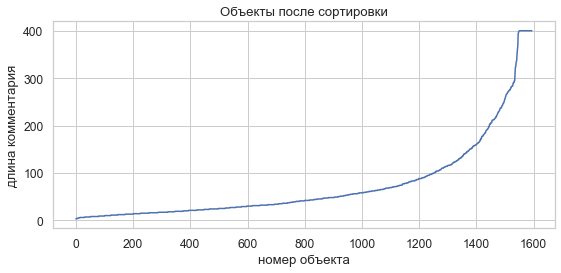

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,4)
sorted_lengths = [len(s[0]) for s in train_samples]
plt.plot(range(0, len(sorted_lengths)), sorted_lengths)
plt.xlabel('номер объекта')
plt.ylabel('длина комментария')
plt.title('Объекты после сортировки')
plt.tight_layout()
plt.show()

Вот здеь хорошо видно, что большая часть датасета - короткие текстовые вектора

In [69]:
batch_size = 16
#кроме текстов я собираю метки и индексы, чтобы сопоставить упорядоченные эмбеддинги изначальному датасету
#и это очень пригодилось, когда процесс упал с ошибкой
batch_ordered_texts = []
batch_ordered_labels = []
batch_ordered_indexes = []

range_upper_limit = 1 + len(train_samples)//batch_size

#иду по части train_samples, размер которой кратен числу пакетов
for i in notebook.tqdm( range(0, range_upper_limit) ) :
    
    #выбираю пакет
    batch = train_samples[ i*batch_size : (i+1)*batch_size ]
    
    #каждый объект в пакете - это кортеж из токенизированного текста, метки и изначального индекса
    #разделяю их
    batch_ordered_texts.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])
    batch_ordered_indexes.append([s[2] for s in batch])

#удаляю train samples, чтобы разгрузить память
del train_samples

In [70]:
batch_ordered_labels[:5]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]]

In [71]:
len(batch_ordered_texts), len(batch_ordered_labels), len(batch_ordered_indexes)

(100, 100, 100)

In [72]:
batch_padded_texts = []
batch_attn_masks = []

for i in notebook.tqdm( range(0, len(batch_ordered_texts)) ):
    batch = batch_ordered_texts[i]
    padded = vectors_padding(batch)
    attention_mask = np.where(padded != 0, 1, 0)
    batch_padded_texts.append(padded)
    batch_attn_masks.append(attention_mask)

In [73]:
display(batch_padded_texts[10])
display(batch_attn_masks[10])

array([[  101,  9152,  3215,  2818,  3489,  2023,  2003,  1996,  4957,
         2000,  3319,   102,     0],
       [  101,  1999,  1998,  2069, 24501, 27082,  2094,  6822,  2008,
         5038,  1999,   102,     0],
       [  101,  8840,  2140,  1051, 11923,  1045,  3214,  2026, 27571,
         2546,  2831,   102,     0],
       [  101,  2017,  2031,  2042,  8534,  2005,  2847,  2831,  9530,
        18886,  5910,   102,     0],
       [  101,  2128, 16009,  3431,  6616,  2125, 10041,  5310,  3147,
        12618,  8322,   102,     0],
       [  101,  2233, 11396,  2808,  1997,  4623,  2024,  2025,  8152,
         8182,  2831,   102,     0],
       [  101,  1045,  3305,  2085,  1045,  2097,  3191,  2013,  1996,
         2518,  2100,   102,     0],
       [  101,  2417,  7442,  6593,  2831,  2358,  7723,  1005,  1055,
         2902, 28425,   102,     0],
       [  101,  1045,  2031,  3880,  2000,  2115,  5227,  2006,  2115,
         2831,  3931,   102,     0],
       [  101,  3395,  2073,

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [74]:
len(batch_padded_texts)

100

In [75]:
%%time
embeddings = [] #при записи в файл данная строка не нужна
for i in notebook.tqdm( range(0, len(batch_padded_texts)) ):
    batch = torch.LongTensor(batch_padded_texts[i]) 
    mask_batch = torch.LongTensor(batch_attn_masks[i])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy()) #при записи в файл данная строка не нужна
#     with open('embeddings_light.csv', 'a') as fp:
#         for row in batch_embeddings[0][:,0,:].numpy():
#             csv.writer(fp, delimiter=",").writerow(row)


Wall time: 1min 57s


In [76]:
y_bert = []
ind_bert = []
for labels in batch_ordered_labels:
    y_bert += labels

for ind in batch_ordered_indexes:
    ind_bert += ind
    
len(y_bert), len(ind_bert)

(1595, 1595)

In [77]:
embeddings_df = pd.DataFrame(np.concatenate(embeddings))#при записи в файл данная строка не нужна
#embeddings_df = pd.read_csv('embeddings_light.csv', header = None) #при записи в файл раскомментировать

In [78]:
len(embeddings_df)

1595

In [79]:
#изначально я предполагал сравнивать с предсказаниями других моделей на их тесте,
#поэтому собирал датасет и упорядочивал его согласно изначальным индексам
#а затем делил на np.array
#возможно, не самый оптимальный подход, но помог при падении ядра
embeddings_df.loc[:, 'toxic'] = y_bert
embeddings_df.index = ind_bert
embeddings_df.sort_index(inplace=True)
#на полном датасете было около 300 nan, возможно, в связи с падением процесса
embeddings_df.fillna(0, inplace = True)
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
126,-0.702640,0.189393,-0.078365,-0.271436,-0.656767,0.253748,0.102763,1.084641,-0.165862,-0.425184,...,-0.354917,0.022897,-0.729087,0.407214,-0.549863,-0.610985,-0.119268,0.443020,0.361566,0
177,-0.566810,0.109878,0.141035,-0.393483,0.152481,-0.276171,0.212249,0.382914,-0.132682,-0.244495,...,0.031573,0.365090,0.031150,-0.283040,-0.144459,-0.085462,-0.329101,0.473700,0.125089,0
215,0.098102,0.005101,-0.082653,-0.026029,-0.160023,-0.518725,0.447245,0.497125,0.065516,-0.177982,...,0.242854,0.343632,-0.077081,-0.060330,0.032362,-0.057464,-0.247976,0.429186,0.729174,0
248,-0.199827,0.572571,-0.321351,0.022956,-0.296194,-0.057194,0.678060,0.589858,-0.523916,-0.498981,...,0.051718,0.006724,0.204458,-0.021316,-0.119137,0.281101,-0.519684,0.526997,0.472728,0
314,-0.299016,-0.262969,0.241281,-0.127563,-0.224833,-0.182682,0.545353,0.548591,-0.161481,-0.220912,...,-0.120513,0.091539,0.154801,0.271337,-0.151544,-0.104738,-0.543858,0.372585,0.571242,0


In [80]:
X_bert = embeddings_df.drop(columns=['toxic']).values
y_bert = embeddings_df['toxic']
del embeddings_df

In [81]:
X_bert_train, X_bert_test, y_bert_train, y_bert_test = \
train_test_split(X_bert, y_bert, test_size=0.1, stratify = y_bert, random_state = 27)

In [92]:
%%time
logreg = LogisticRegression(solver='saga', 
                            max_iter=10000, 
                            class_weight={1:2, 0:1}, 
                            C=5,
                            verbose=1)
logreg.fit(X_bert_train, y_bert_train)
y_bert_test_predicted  = logreg.predict(X_bert_test)
print_report(y_bert_test, y_bert_test_predicted)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 951 epochs took 11 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s finished


,Predicted NO,Predicted YES
Actual NO,139,5
Actual YES,10,6


---------------------------report---------------------------

               precision    recall  f1-score   support

           0       0.93      0.97      0.95       144
           1       0.55      0.38      0.44        16

    accuracy                           0.91       160
   macro avg       0.74      0.67      0.70       160
weighted avg       0.89      0.91      0.90       160

ROC_AUC: 0.67
Wall time: 11.5 s


**Данные и результаты BERT на полном наборе данных:**

<img src="https://getfile.dokpub.com/yandex/get/https://yadi.sk/i/5e1x65QX9nX0mg">

<img src="https://getfile.dokpub.com/yandex/get/https://yadi.sk/i/oamREYdN1mNs8Q">

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Вывод</h1>

Лучше всего себя показала комбинация:

In [93]:
final_pipe

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'ain', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another', ...})),
                ('model',
                 LogisticRegression(C=20, class_weight={0: 1, 1: 3.5},
                                    max_iter=10000, solver='saga',
                                    verbose=1))])

In [94]:
print('f1_score', final_f1)

f1_score 0.7817715019255456


На данном датасете BERT+LogisticRegression показал результат хуже. Есть большое количество вариантов, что попробовать ещё, но все они (большинство) требуют GPU в colab или чего-то аналогичного. Наверняка можно "выжать" больше из BERT. spaCy была только опробована на простой модели на маленькой выборке. Наверняка на полной выборке и более сложной модели результат будет гораздо лучше. Но по скорости + качество вполне достойный бейзлайн - TfidfVectorizer + LogisticRegression.